In [1]:
import warnings
from utils.plotting_helpers import plot_weights
from environements.portfolio_optimization_env_flat import PortfolioOptimizationEnvFlat
import matplotlib as mpl
from utils.portfolio_trainer import PortfolioOptimization
from pandas import read_csv
from utils.feature_engineer import FeatureEngineer
from utils.helpers import data_split
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
from utils.plotting_helpers import plot_mvo_weights
import utils.mean_variance_optimization as mvo
df_dow = read_csv('./data/dow.csv')
from utils.mean_variance_optimization import mvo_data

# mpl.rcParams['figure.dpi'] = 300
import math
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')
warnings.filterwarnings("ignore")


def linear_schedule(initial_value):
    def scheduler(progress_remaining):
        return initial_value * progress_remaining
    return scheduler

In [2]:
df = df_dow.copy()

df = df_dow[df_dow.tic.isin([ 'AXP', 'DIS', 'GS', 'MMM', 'UNH','MCD','CAT','CRM','V','AMGN','TRV','MSFT'])]
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'
INDICATORS = [
    "macd",
    "rsi_30",
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list=INDICATORS,
                     use_turbulence=False,
                     user_defined_feature=True)

processed_prcies = fe.preprocess_data(df.query('date>"2000-01-01"'))
cleaned_data = processed_prcies.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf, 0)
stock_dimension = len(cleaned_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 10


In [3]:
# Compute exponentially weighted std of log returns
for window in [21, 42, 63]:
    cleaned_data[f'std_return_{window}'] = cleaned_data.groupby('tic')['log_return'] \
        .transform(lambda x: x.ewm(span=window, min_periods=10,adjust=False).std())
# Compute exponentially weighted std of closing prices for MACD normalization
cleaned_data['ewma_std_price_63'] = cleaned_data.groupby('tic')['close'] \
    .transform(lambda x: x.ewm(span=63, min_periods=10,adjust=False).std())

# Normalize MACD by price volatility
cleaned_data['macd_normal'] = cleaned_data['macd'] / cleaned_data['ewma_std_price_63']

# Rolling cumulative log returns over different periods
for window in [21, 42, 63]:
    cleaned_data[f'return_sum_{window}'] = cleaned_data.groupby('tic')['log_return'] \
        .transform(lambda x: x.rolling(window=window, min_periods=10).sum())

# Normalize rolling log returns by their respective volatilities
for window in [21, 42, 63]:
    cleaned_data[f'r_{window}'] = cleaned_data[f'return_sum_{window}'] / cleaned_data[f'std_return_{window}']
cleaned_data['rsi_30'] = cleaned_data['rsi_30'].map(lambda x: 1 if x >= 70 else (0.5 if x <= 30 else 0))

In [4]:
covs = mvo.mvo_data(cleaned_data,risk_model='sample_cov')

In [10]:
cleaned_data = covs.fillna(0)
cleaned_data.isna().sum()

Unnamed: 0           0
date                 0
open                 0
high                 0
low                  0
close                0
volume               0
tic                  0
day                  0
macd                 0
rsi_30               0
return               0
log_return           0
std_return_21        0
std_return_42        0
std_return_63        0
ewma_std_price_63    0
macd_normal          0
return_sum_21        0
return_sum_42        0
return_sum_63        0
r_21                 0
r_42                 0
r_63                 0
time                 0
cov_list             0
corr_list            0
returns              0
dtype: int64

In [ ]:
with open('./data/dow_processed.pkl', 'wb') as file: 
    pickle.dump(cleaned_data, file) 

In [3]:
with open('./data/dow_processed.pkl', 'rb') as file: 
    cleaned_data = pickle.load(file)

In [4]:
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 10


In [16]:
pv_simple_return = train_data.pivot_table(index='date',values='return',columns='tic')
pv_simple_log_return = train_data.pivot_table(index='date',values='log_return',columns='tic')
pv_simple_rsi = train_data.pivot_table(index='date',values='rsi_30',columns='tic')
pv_simple_macd_normal= train_data.pivot_table(index='date',values='macd_normal',columns='tic')
pv_simple_std= train_data.pivot_table(index='date',values='ewma_std_price_63',columns='tic')
pv_m_21= train_data.pivot_table(index='date',values='return_sum_21',columns='tic')



<Axes: xlabel='date'>

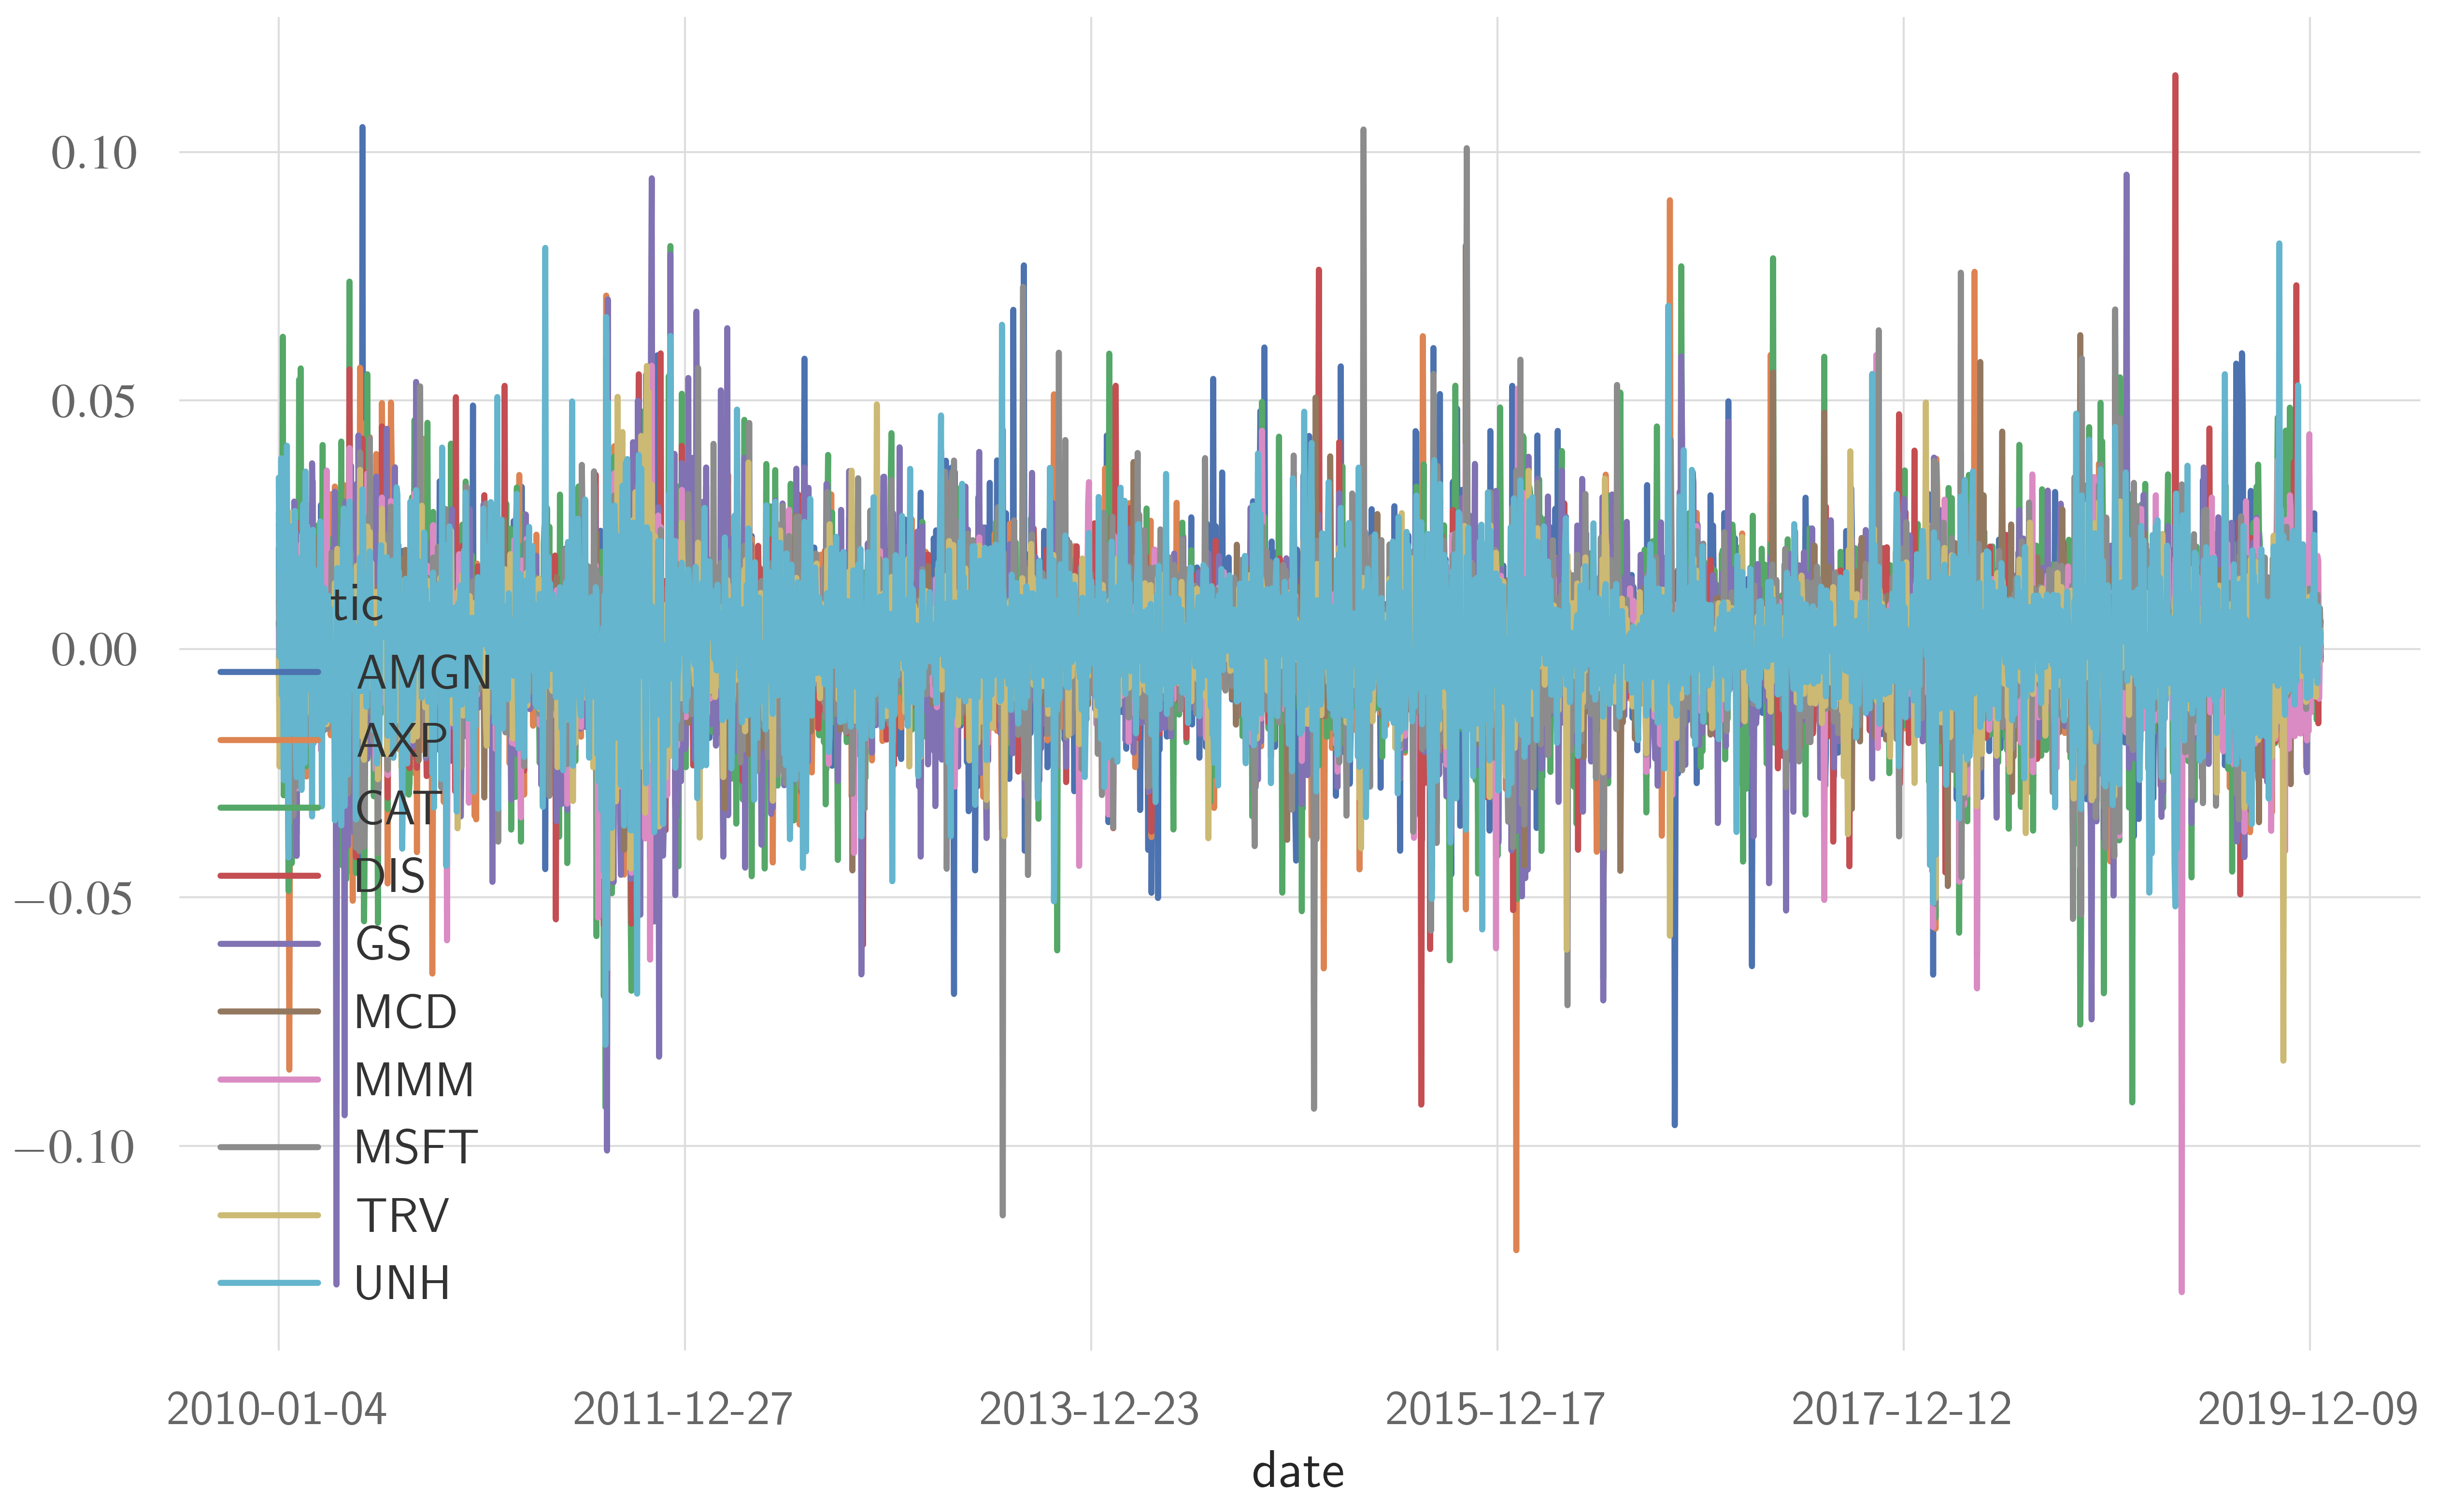

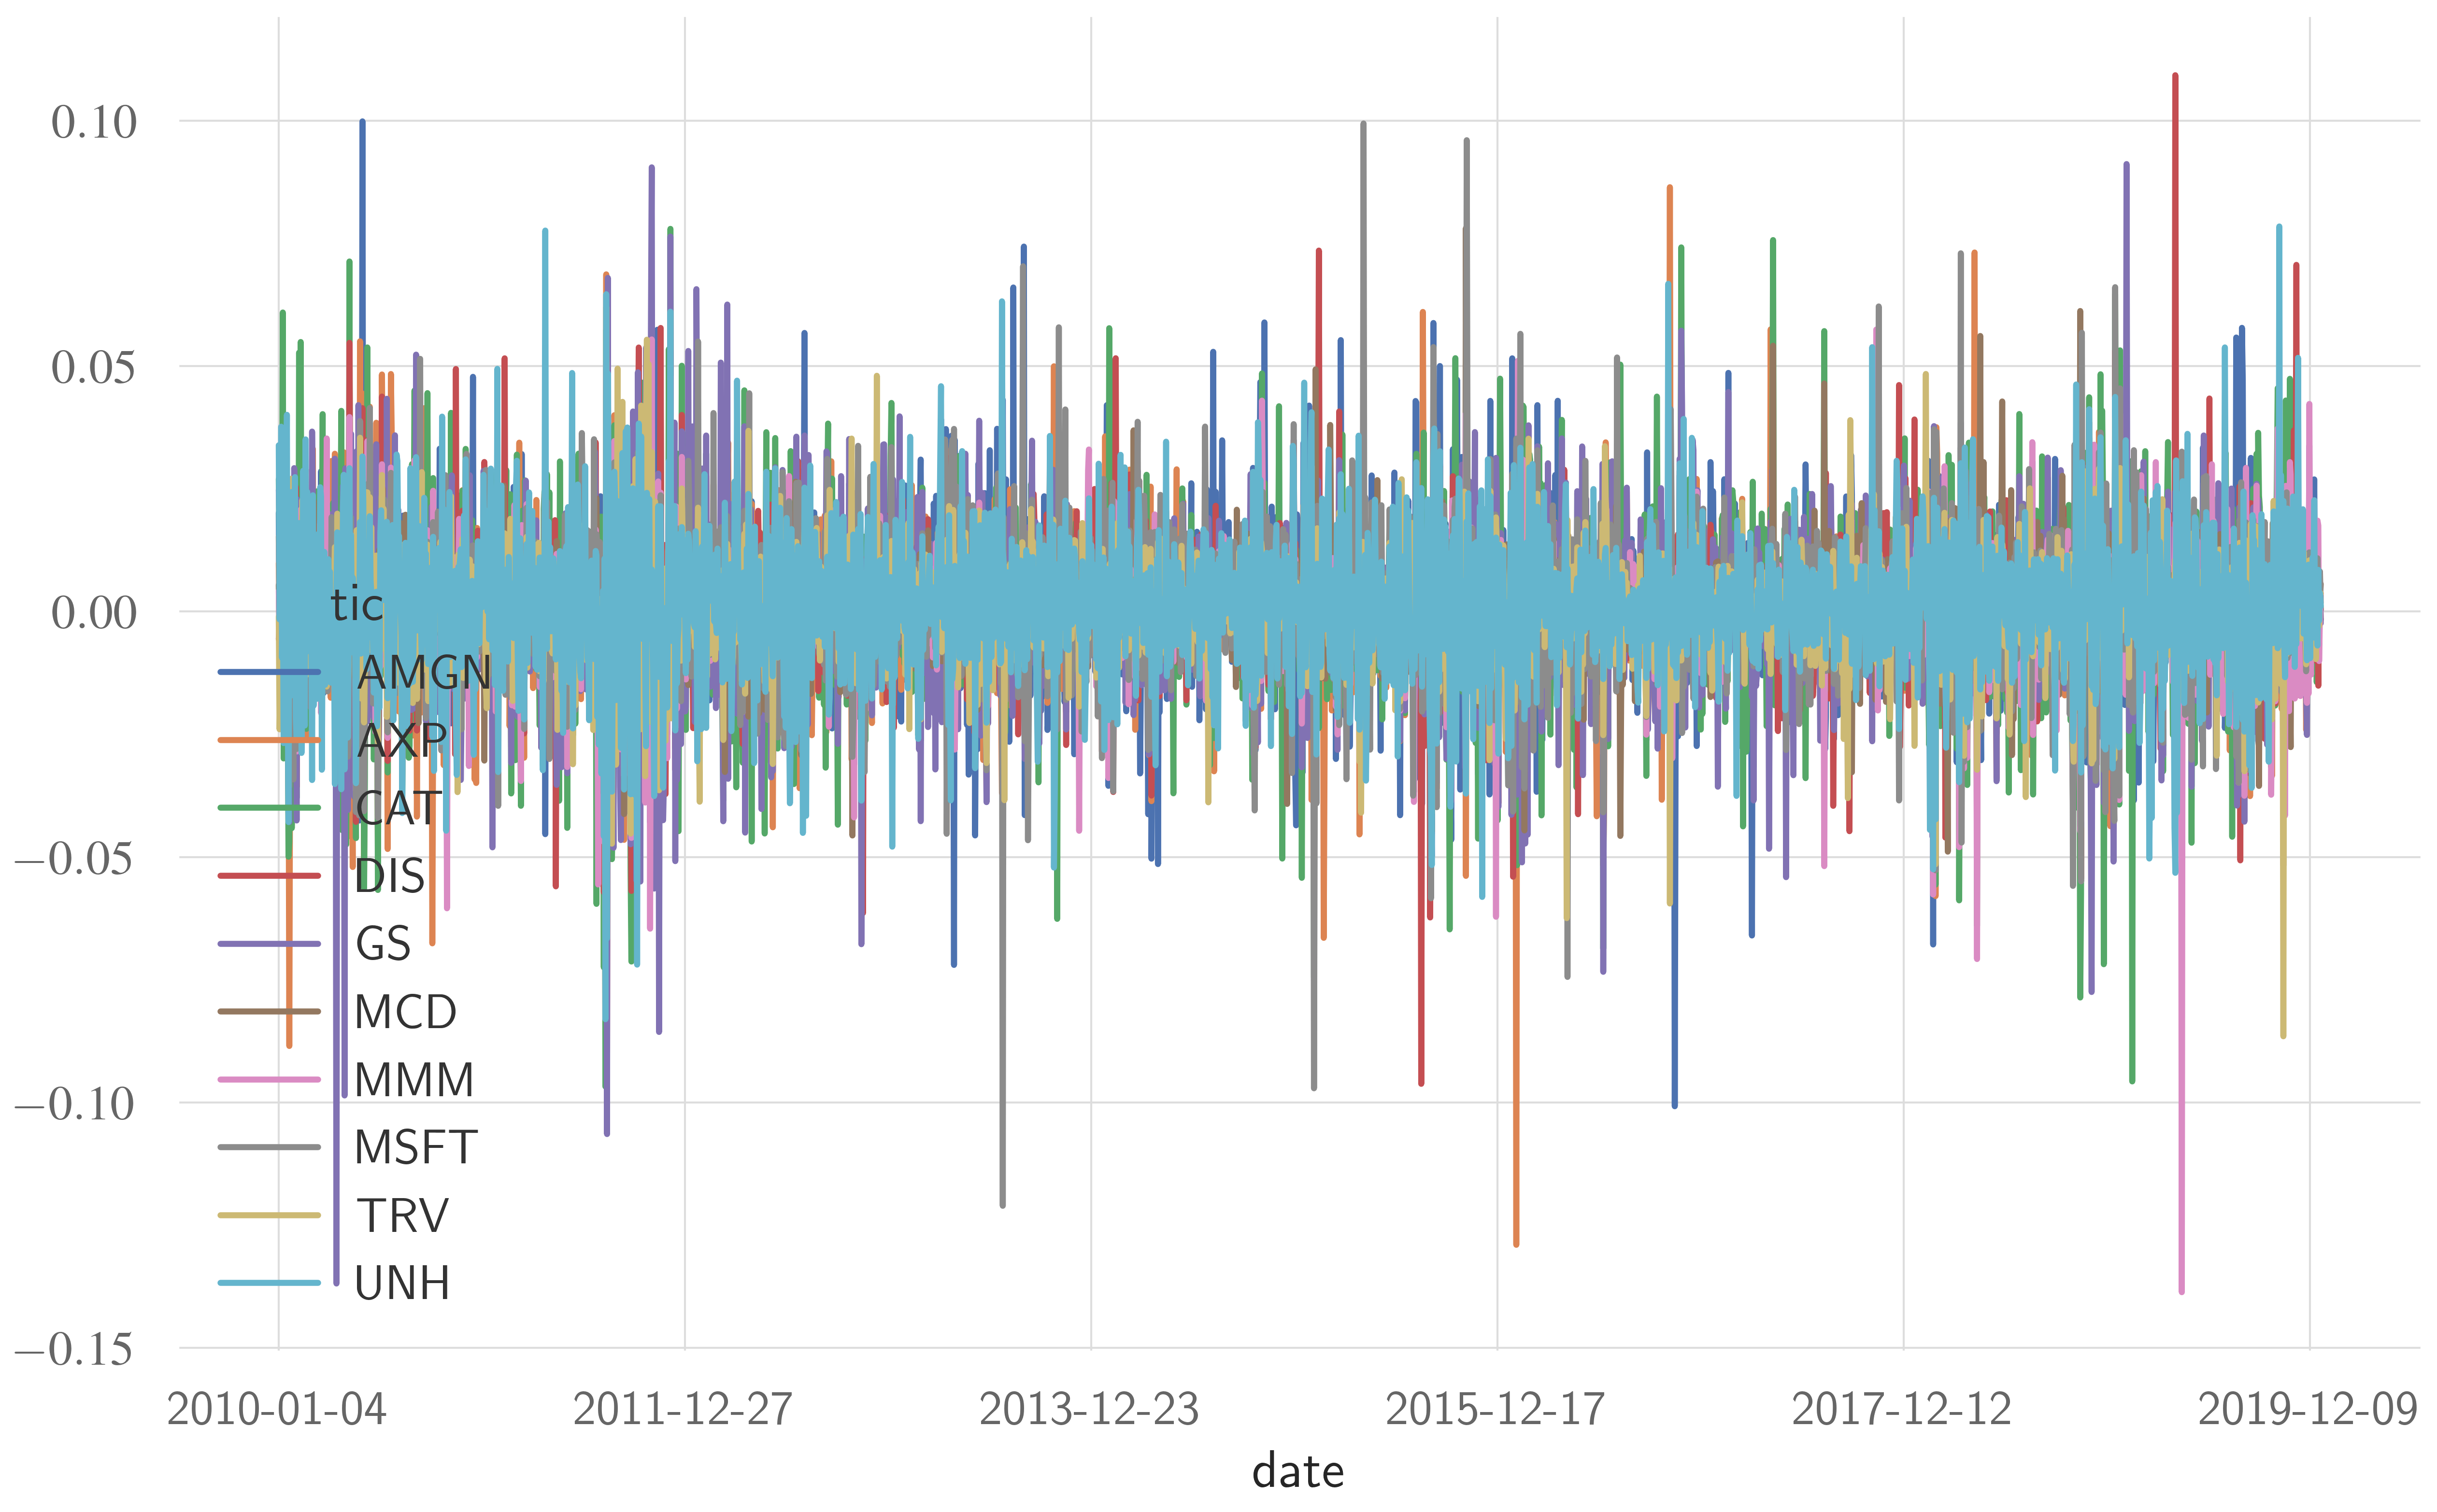

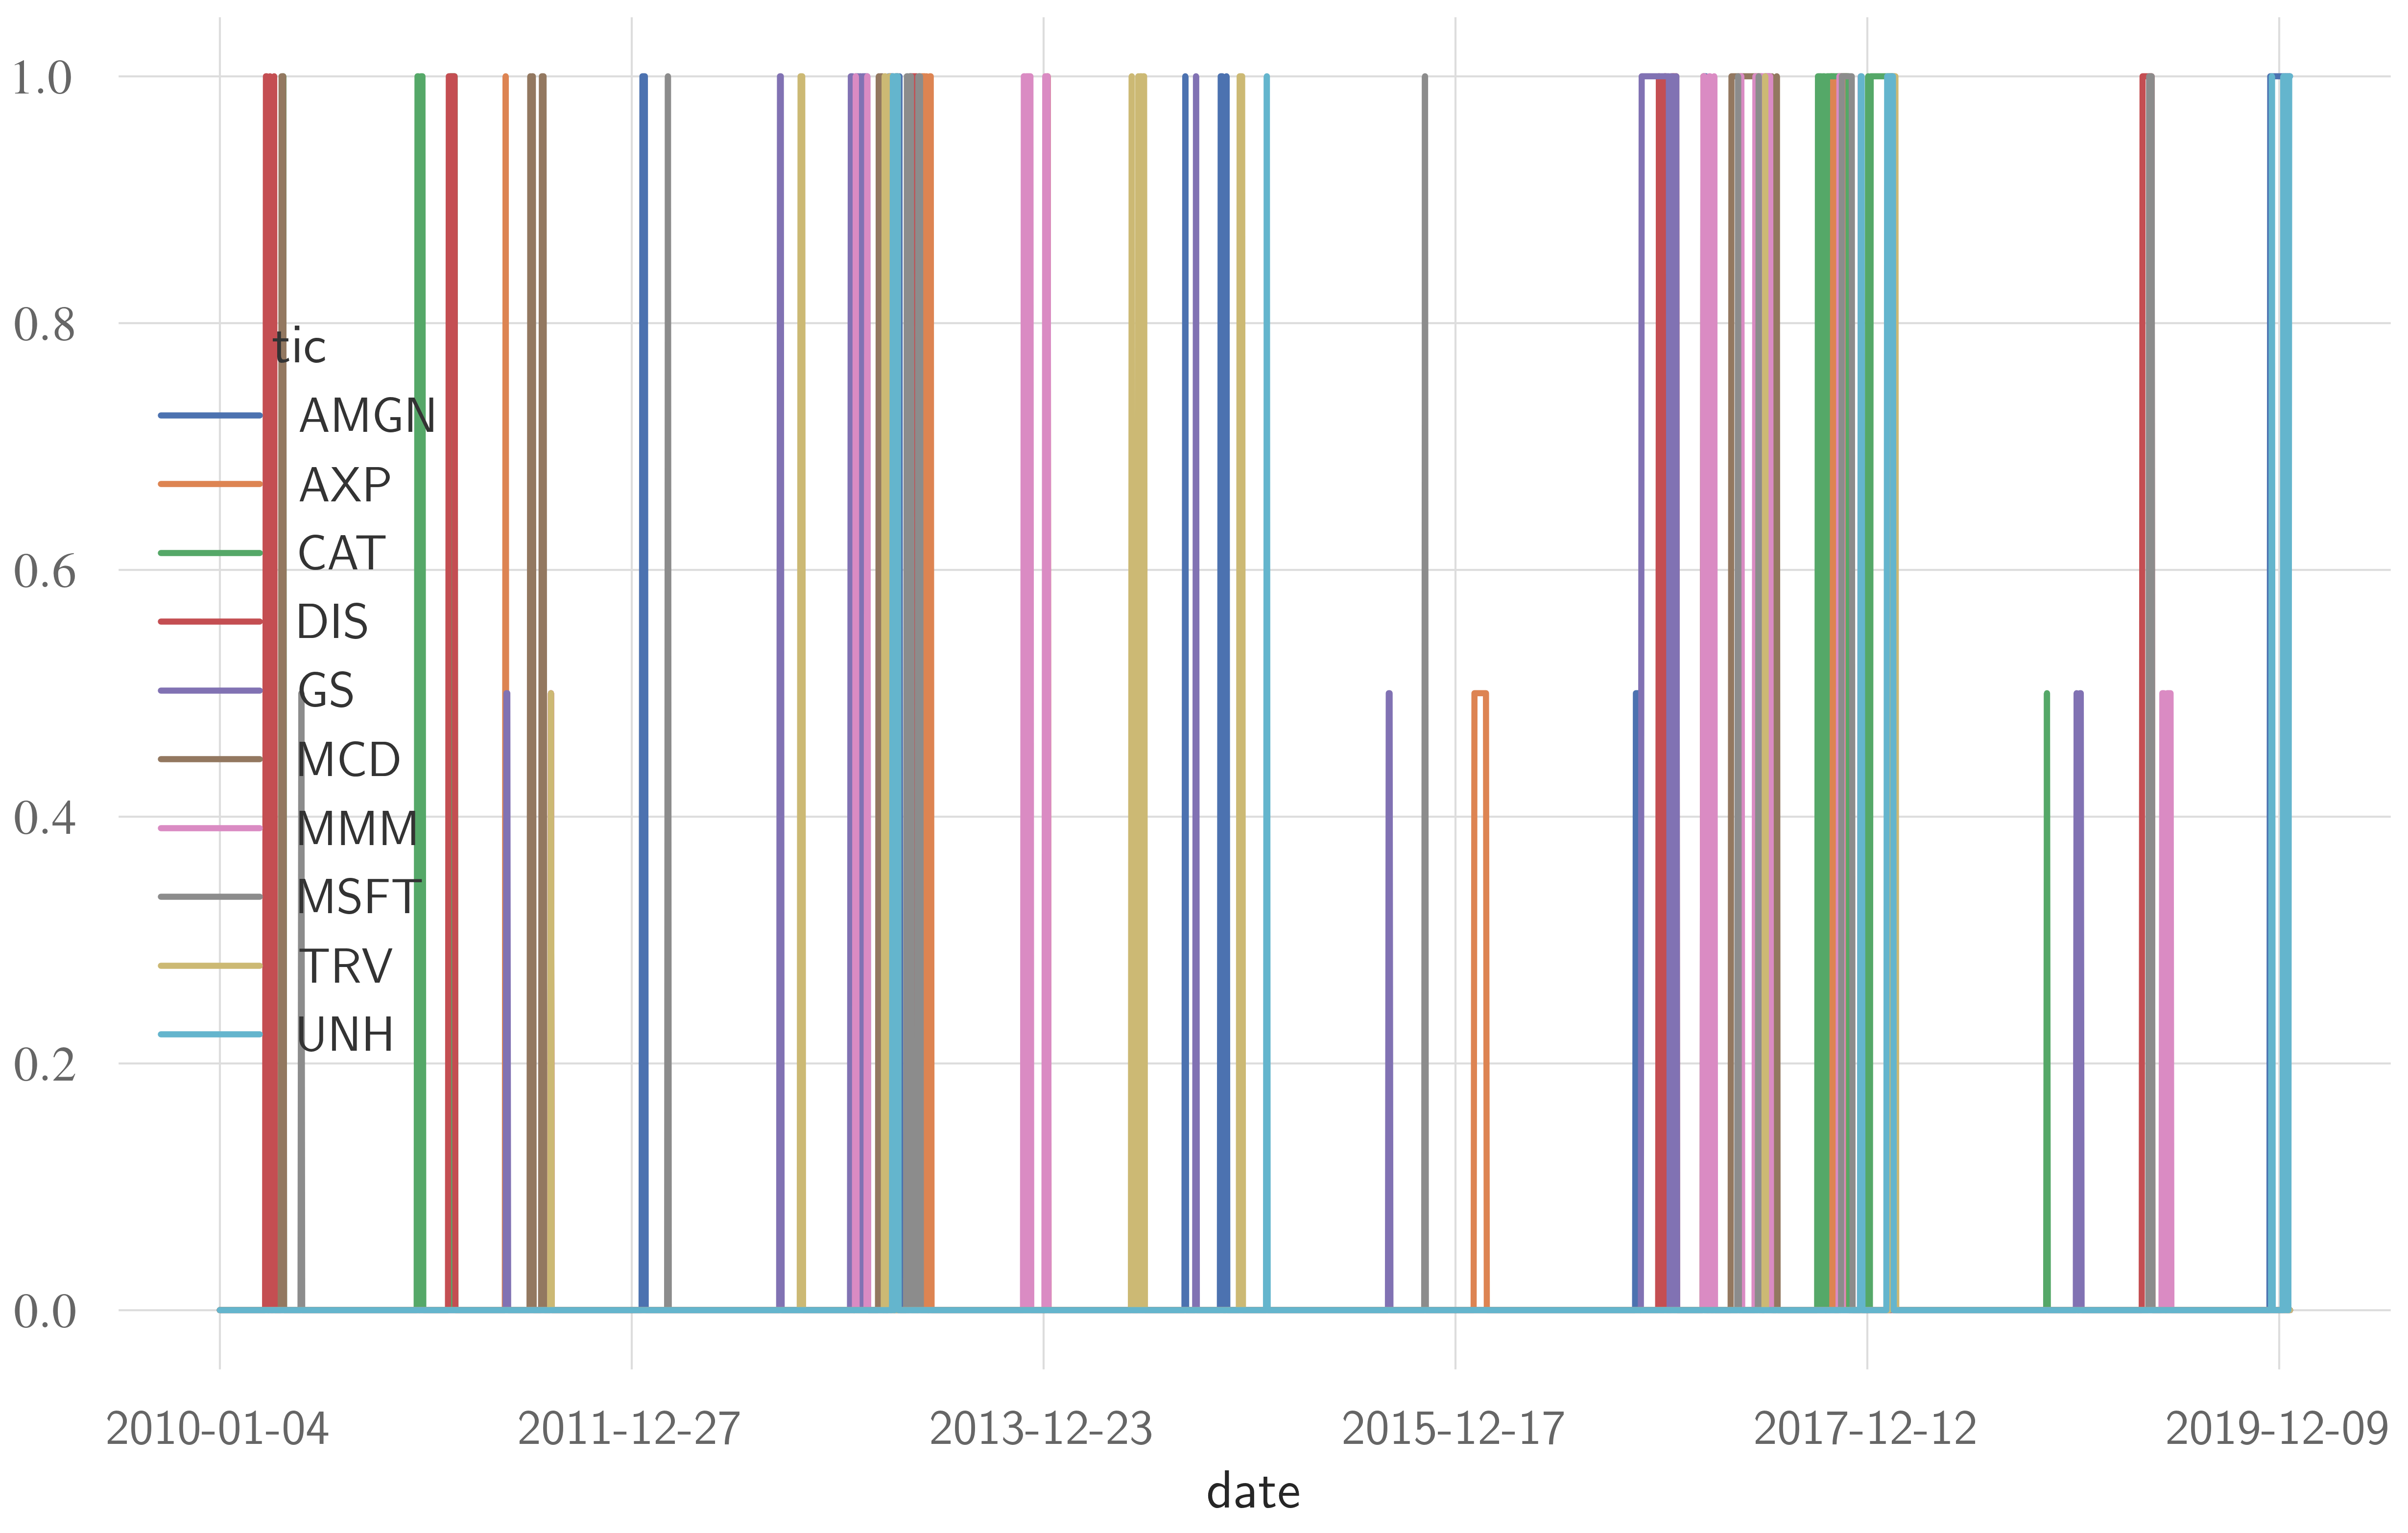

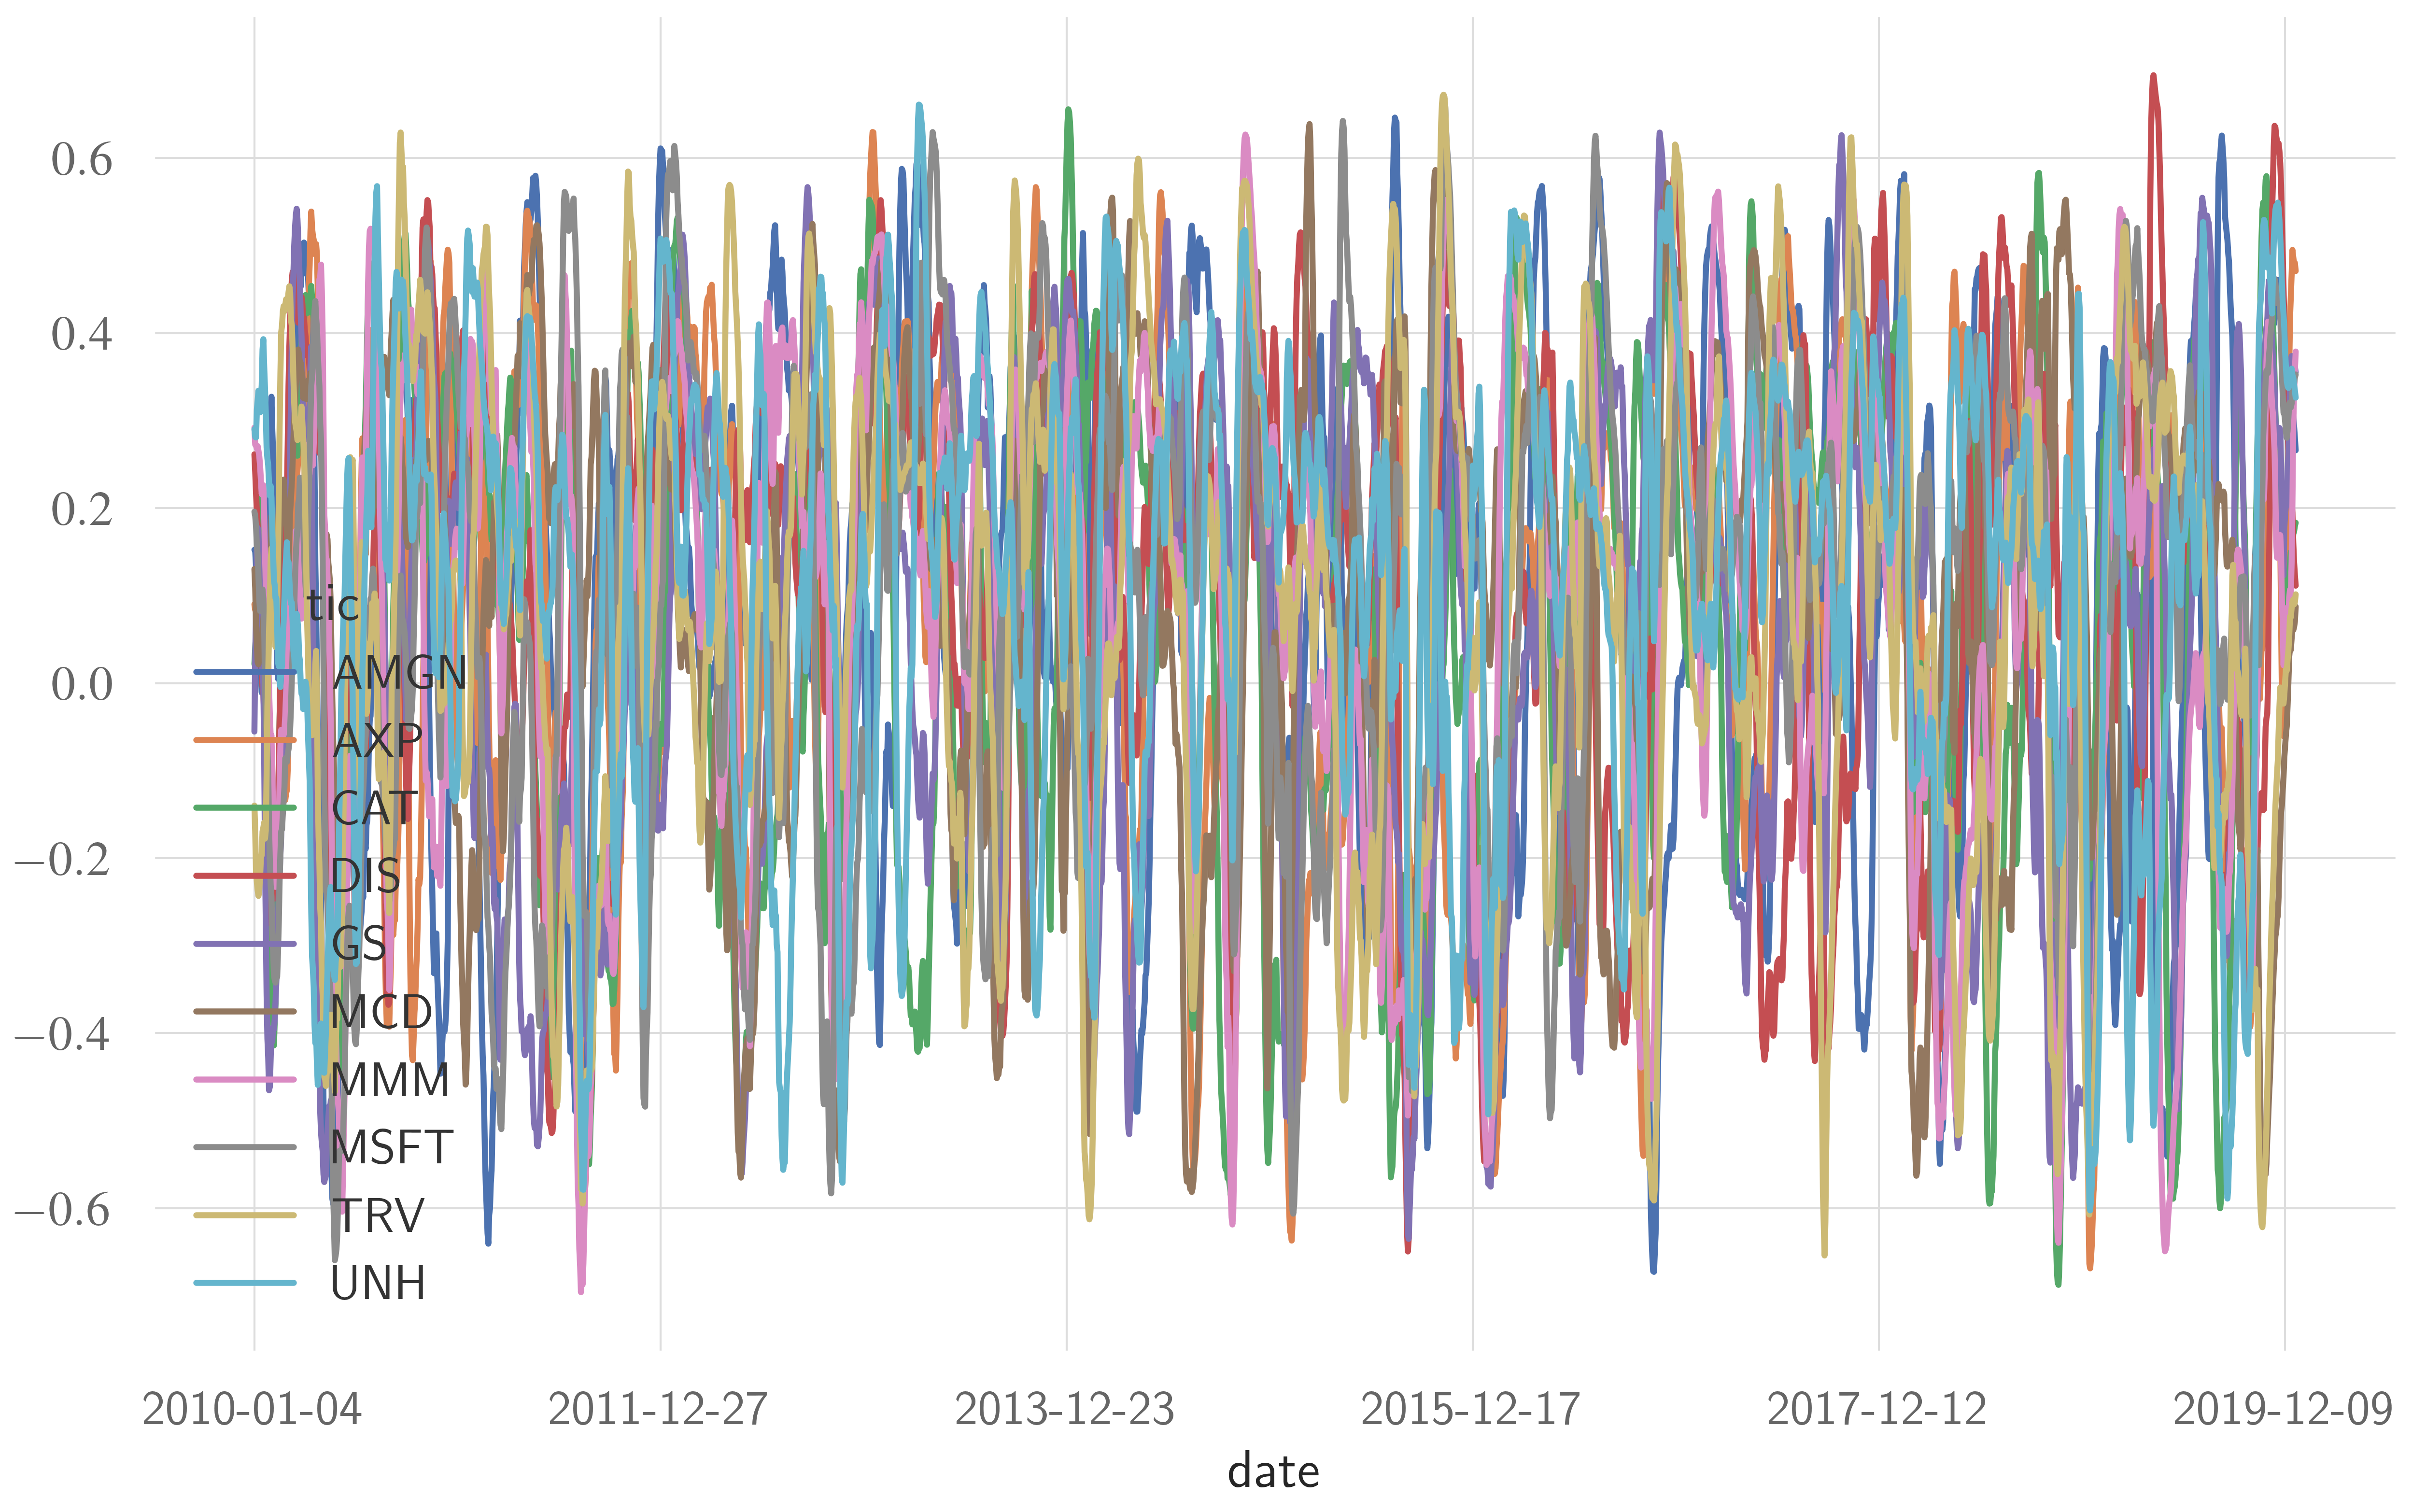

In [17]:
%matplotlib inline

pv_simple_return.plot()
pv_simple_log_return.plot()
pv_simple_rsi.plot()
pv_simple_macd_normal.plot()



# Proximal Policy Optimization

In [5]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0.002, comission_fee_model=None,
    tag="flat_state", sharp_reward=False, last_weight=False, remove_close=True,flatten_state=True,
    add_cash=False, env=PortfolioOptimizationEnv
)
optimizer.train_model(train_data,
                      validation_data,
                      features=["close", "log_return", "r_21", "r_42", "r_63",
                                "macd", "rsi_30","corr_list"
                                ],
                      model_name="ppo",
                      args={"n_steps":  1024, "batch_size": 64, 'learning_rate': 1e-4,
                            'gamma': 0.85, 'gae_lambda': 0.85, 'ent_coef': 0.05},
                      window_size=5,
                      iterations=1000_000)

# test_env = optimizer.create_environment(test_data,features=[
#                                 "close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi","corr_list"
#                                   ],window=60)
# ppo_test_result = optimizer.load_from_file(
#     'td3',test_env, 
#     cwd="data/td3_close_log_return_r_21_r_42_r_63_macd_rsi_window_size_60_0.001_fixed_ppo/td3_800000_steps"
#     ,deterministic=True)

{'n_steps': 1024, 'batch_size': 64, 'learning_rate': 0.0001, 'gamma': 0.85, 'gae_lambda': 0.85, 'ent_coef': 0.05}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_log/close_log_return_r_21_r_42_r_63_macd_rsi_30_corr_list_window_size_5_0.002_flat_state/ppo_1


KeyboardInterrupt: 

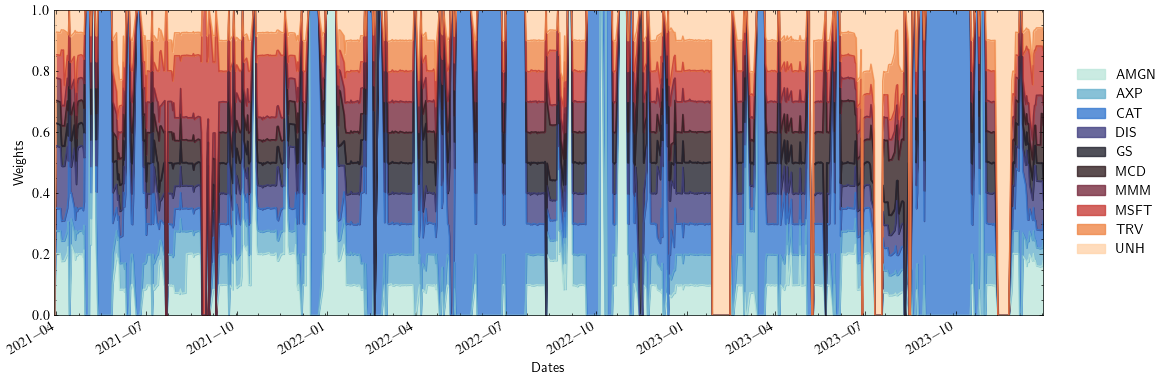

In [66]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

# Mean Variance Optimization

In [67]:
covariances = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE,returns_model='mean_historical_return',risk_model='sample_cov')

In [68]:
min_variacen_portfolio = mvo.mean_variance_optimization(covariances,commission_fee=0,window=5)

Initial portfolio value:1000000
Final portfolio value: 1320929.75
Final accumulative portfolio value: 1.320929765701294
Maximum DrawDown: -0.1566782761864729
Sharpe ratio: 0.7357436946526666


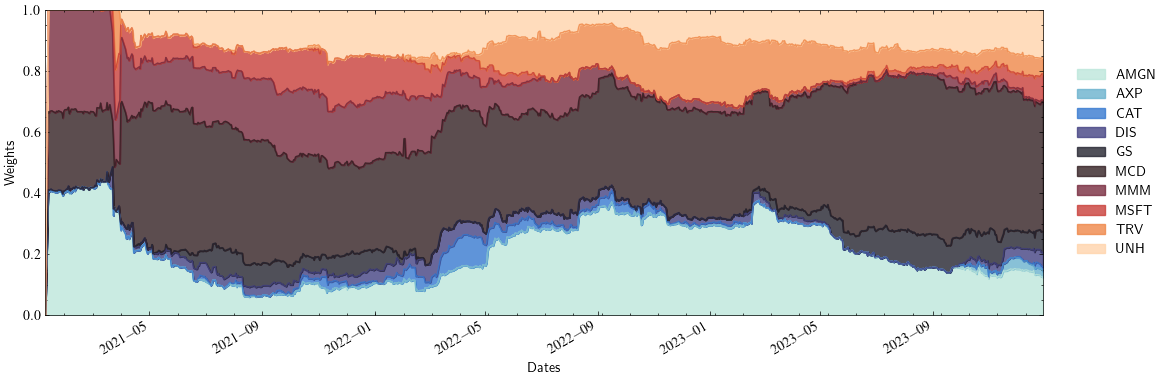

In [69]:
%matplotlib inline
plot_weights(min_variacen_portfolio[0].weights, min_variacen_portfolio[0].date, min_variacen_portfolio[1],add_cash=False)

begin_total_asset:50000
end_total_asset:65829.34679393651
Sharpe:  0.7260201266740914
Test Finished!
episode_return 1.31658693587873


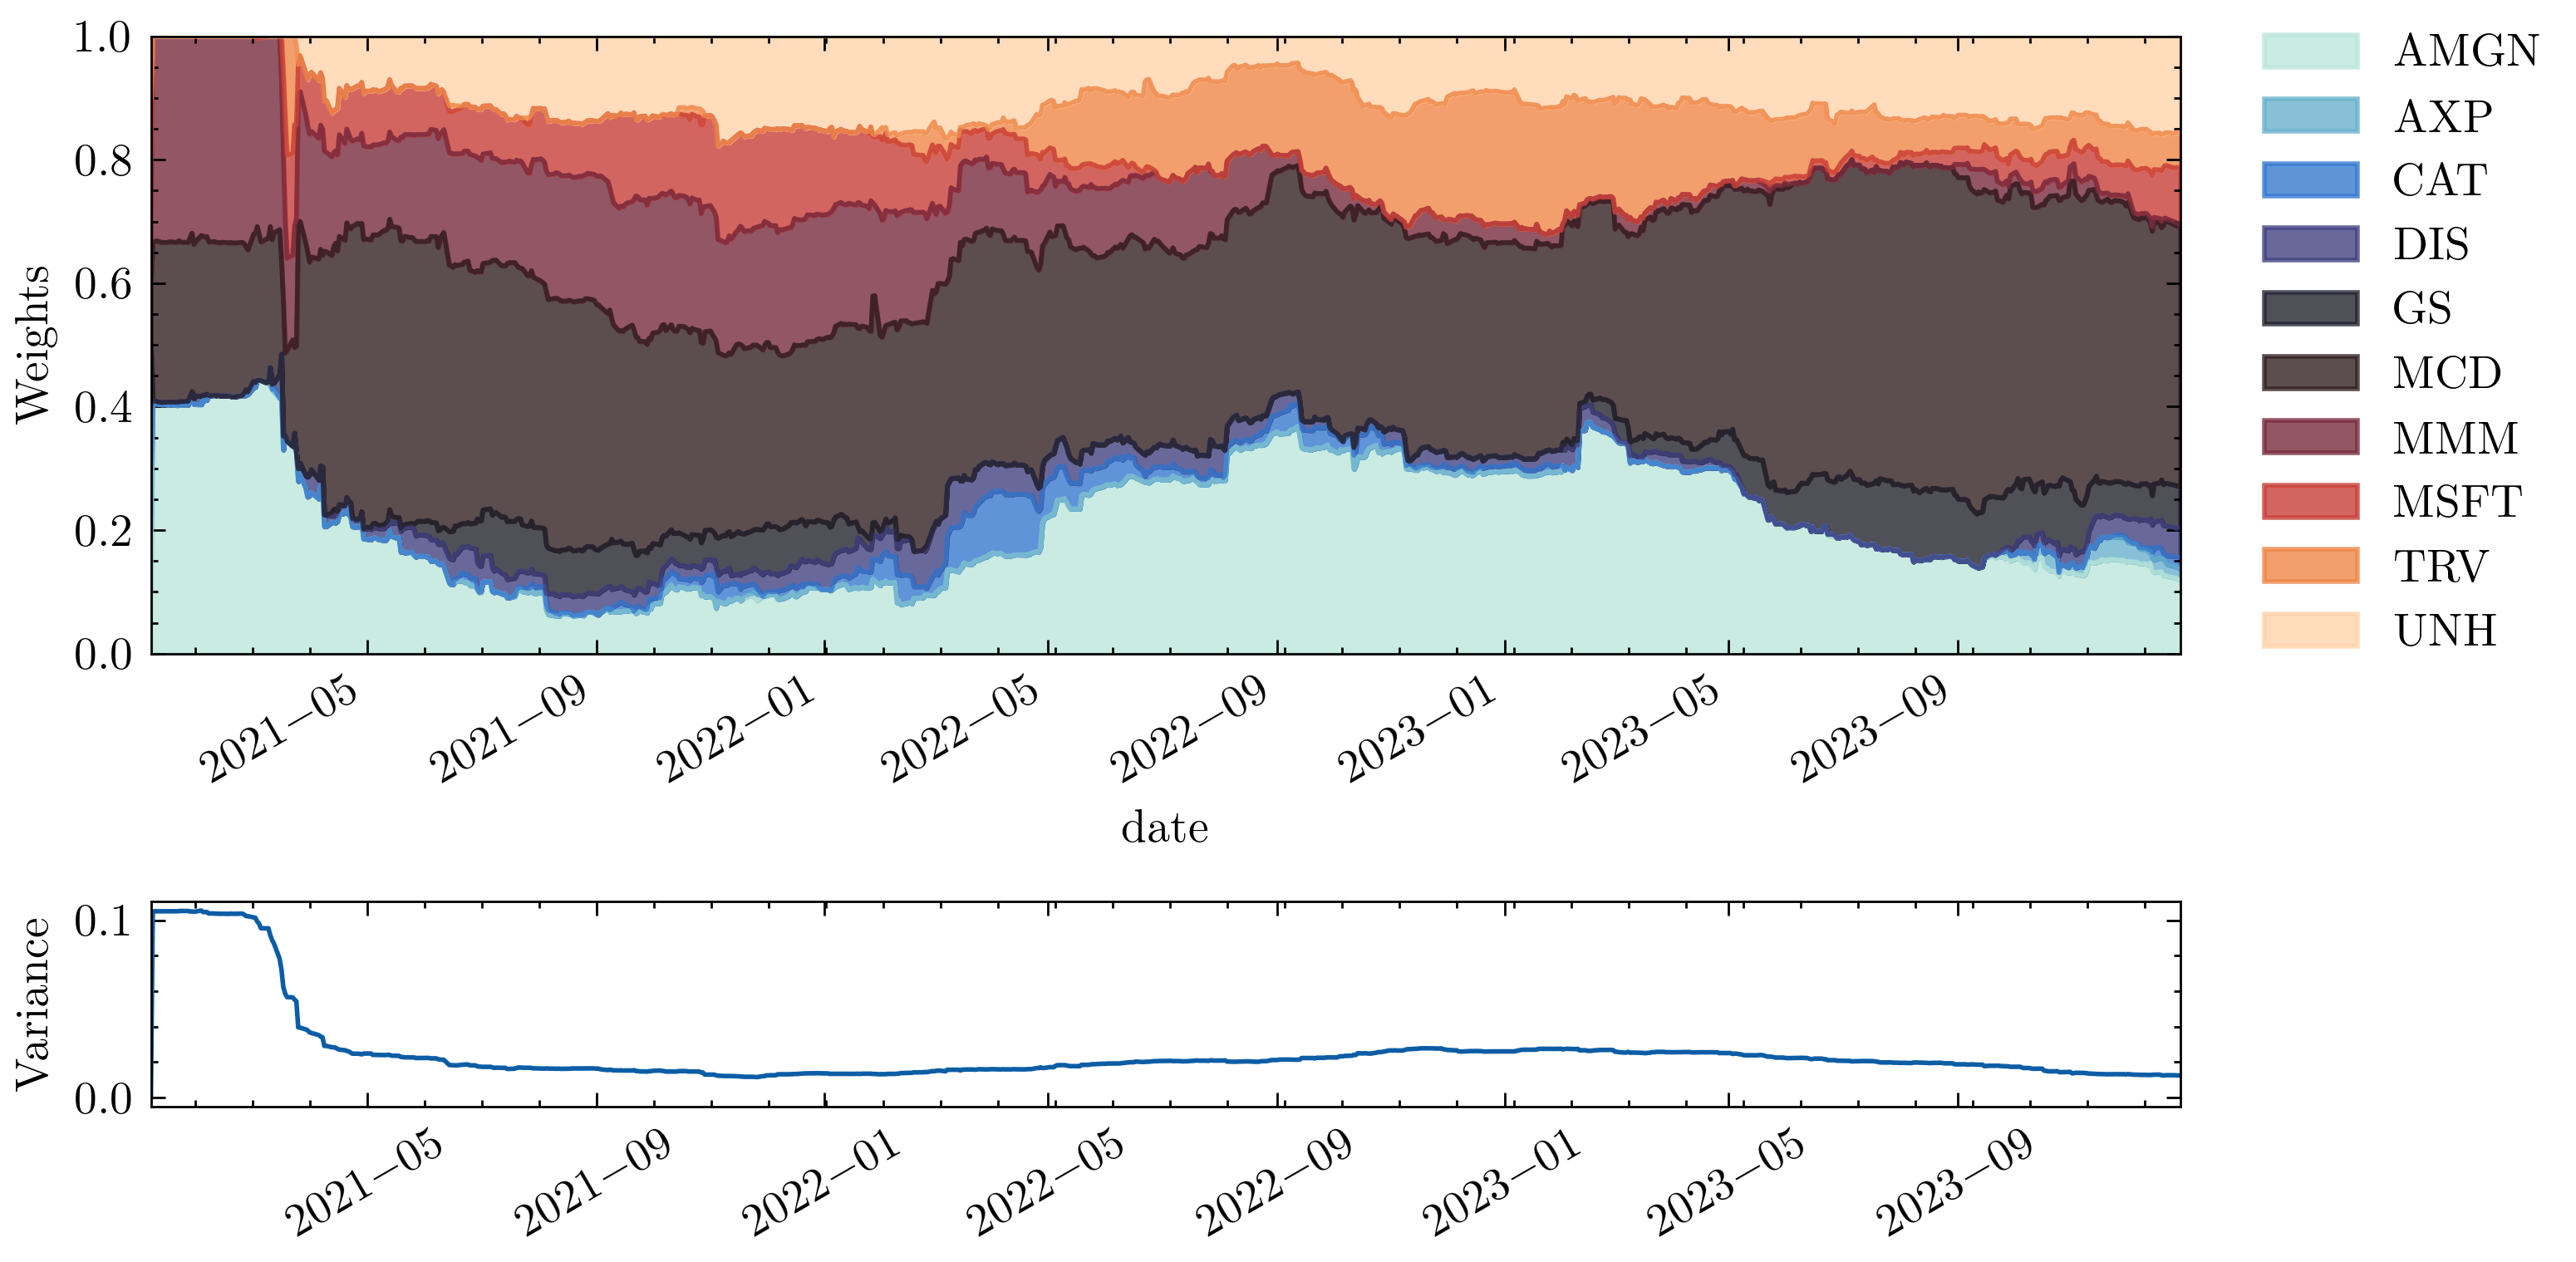

In [6]:
result_sharpe = mvo.mean_variance_optimization(covariances,pct=0)
%matplotlib inline
plot_mvo_weights(result_sharpe,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_sample_cov_mean_sharpe.png')

PPO WITHOUT WEIGHT

In [77]:
covariances.iloc[0].cov_list.values.flatten()

array([0.14750028, 0.10833001, 0.08954757, 0.07828128, 0.10395706,
       0.07255577, 0.07838666, 0.11748899, 0.0875915 , 0.1224203 ,
       0.10833001, 0.41345459, 0.20762211, 0.24135965, 0.28572659,
       0.18471621, 0.16344296, 0.15620794, 0.2229246 , 0.20131614,
       0.08954757, 0.20762211, 0.20154652, 0.14693018, 0.17160124,
       0.10832519, 0.13147158, 0.1058653 , 0.13543312, 0.12532718,
       0.07828128, 0.24135965, 0.14693018, 0.24089238, 0.18719151,
       0.12777736, 0.11751924, 0.1249991 , 0.1278655 , 0.12572795,
       0.10395706, 0.28572659, 0.17160124, 0.18719151, 0.27328431,
       0.14867832, 0.13910597, 0.14831172, 0.18398182, 0.16940587,
       0.07255577, 0.18471621, 0.10832519, 0.12777736, 0.14867832,
       0.16135629, 0.10075663, 0.11542435, 0.13041041, 0.12442064,
       0.07838666, 0.16344296, 0.13147158, 0.11751924, 0.13910597,
       0.10075663, 0.14007463, 0.08826113, 0.1068194 , 0.1112832 ,
       0.11748899, 0.15620794, 0.1058653 , 0.1249991 , 0.14831

Use normalization

In [ ]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0.00, comission_fee_model=None, vectorize=False, normalize=None,
    tag="ppo_alternative_state_11_asset", sharp_reward=False, last_weight=False, remove_close=True,
    add_cash=False, env=PortfolioOptimizationEnv
    )
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","momentum_return_21_normal"
#                                   ,"momentum_return_42_normal","momentum_return_63_normal",
#                                   "macd_normal","rsi_normal"
#                                   ],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 64,'learning_rate':1e-4,'gamma':0.90 ,'gae_lambda': 0.85, 'ent_coef': 0.05},
#                         window_size=60,
#                         iterations=400_000)
test_env = optimizer.create_environment(test_data,features=["close", "log_return", "r_21_normal",
                                "r_42_normal", "r_63_normal", "r_252_normal", "macd_normal", "rsi_normal"
                                  ],window=60)
ppo_test_result = optimizer.load_from_file(
    'ppo',test_env, 
    cwd="data\ppo_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_portfolio_return_ppo\ppo_260000_steps"
    ,deterministic=True)


Successfully load model data\ppo_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_portfolio_return_ppo\ppo_260000_steps
Initial portfolio value:250000
Final portfolio value: 262199.625
Final accumulative portfolio value: 1.0487984418869019
Maximum DrawDown: -0.2204810883074637
Sharpe ratio: 0.23582026443643747


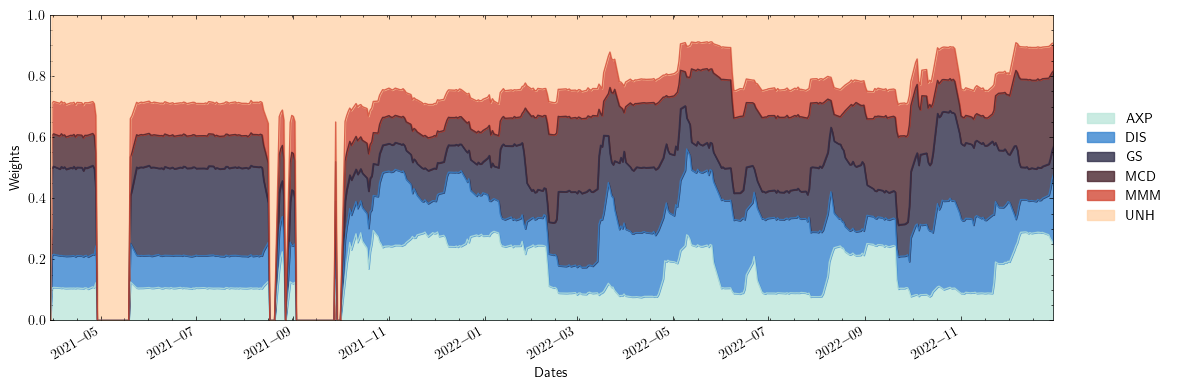

In [ ]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

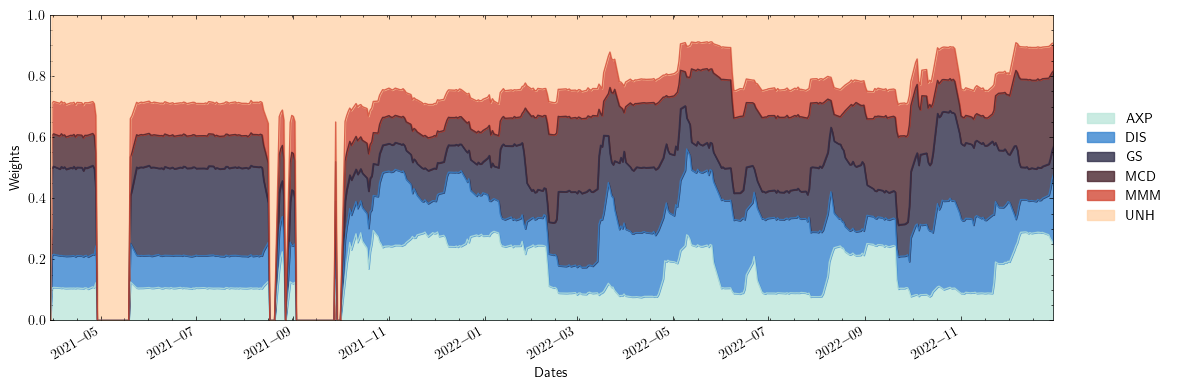

In [ ]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

In [ ]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0.00, comission_fee_model=None, vectorize=False, normalize=None,
    tag="ppo_alternative_state_11_asset", sharp_reward=False, last_weight=False, remove_close=True,
    add_cash=False, env=PortfolioOptimizationEnv
    )
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","momentum_return_21_normal"
#                                   ,"momentum_return_42_normal","momentum_return_63_normal",
#                                   "macd_normal","rsi_normal"
#                                   ],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 64,'learning_rate':1e-4,'gamma':0.90 ,'gae_lambda': 0.85, 'ent_coef': 0.05},
#                         window_size=60,
#                         iterations=400_000)
test_env = optimizer.create_environment(test_data,features=["close", "log_return", "r_21_normal",
                                "r_42_normal", "r_63_normal", "r_252_normal", "macd_normal", "rsi_normal"
                                  ],window=60)
a2c_test_result = optimizer.load_from_file(
    'a2c',test_env, 
    cwd="data/a2c_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_a2c_ret/a2c_130000_steps"
    ,deterministic=True)


Successfully load model data/a2c_close_log_return_r_21_normal_r_42_normal_r_63_normal_r_252_normal_macd_rsi_window_size_60_0.003_a2c_ret/a2c_130000_steps
Initial portfolio value:250000
Final portfolio value: 192655.375
Final accumulative portfolio value: 0.7706214785575867
Maximum DrawDown: -0.34089284004725384
Sharpe ratio: -0.5424350110453228


# Buy and Hold

In [5]:
from environements.portfolio_optimization_env import PortfolioOptimizationEnv


stock_dimension = len(test_data.tic.unique())
environment_train_buy_and_hold_sp500 = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0,
    time_window=5,
    features = ["close","return"],
    normalize_df=None,
    add_cash=False
)
terminated = False

environment_train_buy_and_hold_sp500.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated,_, _ = environment_train_buy_and_hold_sp500.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1339321.375
Final accumulative portfolio value: 1.3393213748931885
Maximum DrawDown: -0.18659573293420295
Sharpe ratio: 0.6890450873214902


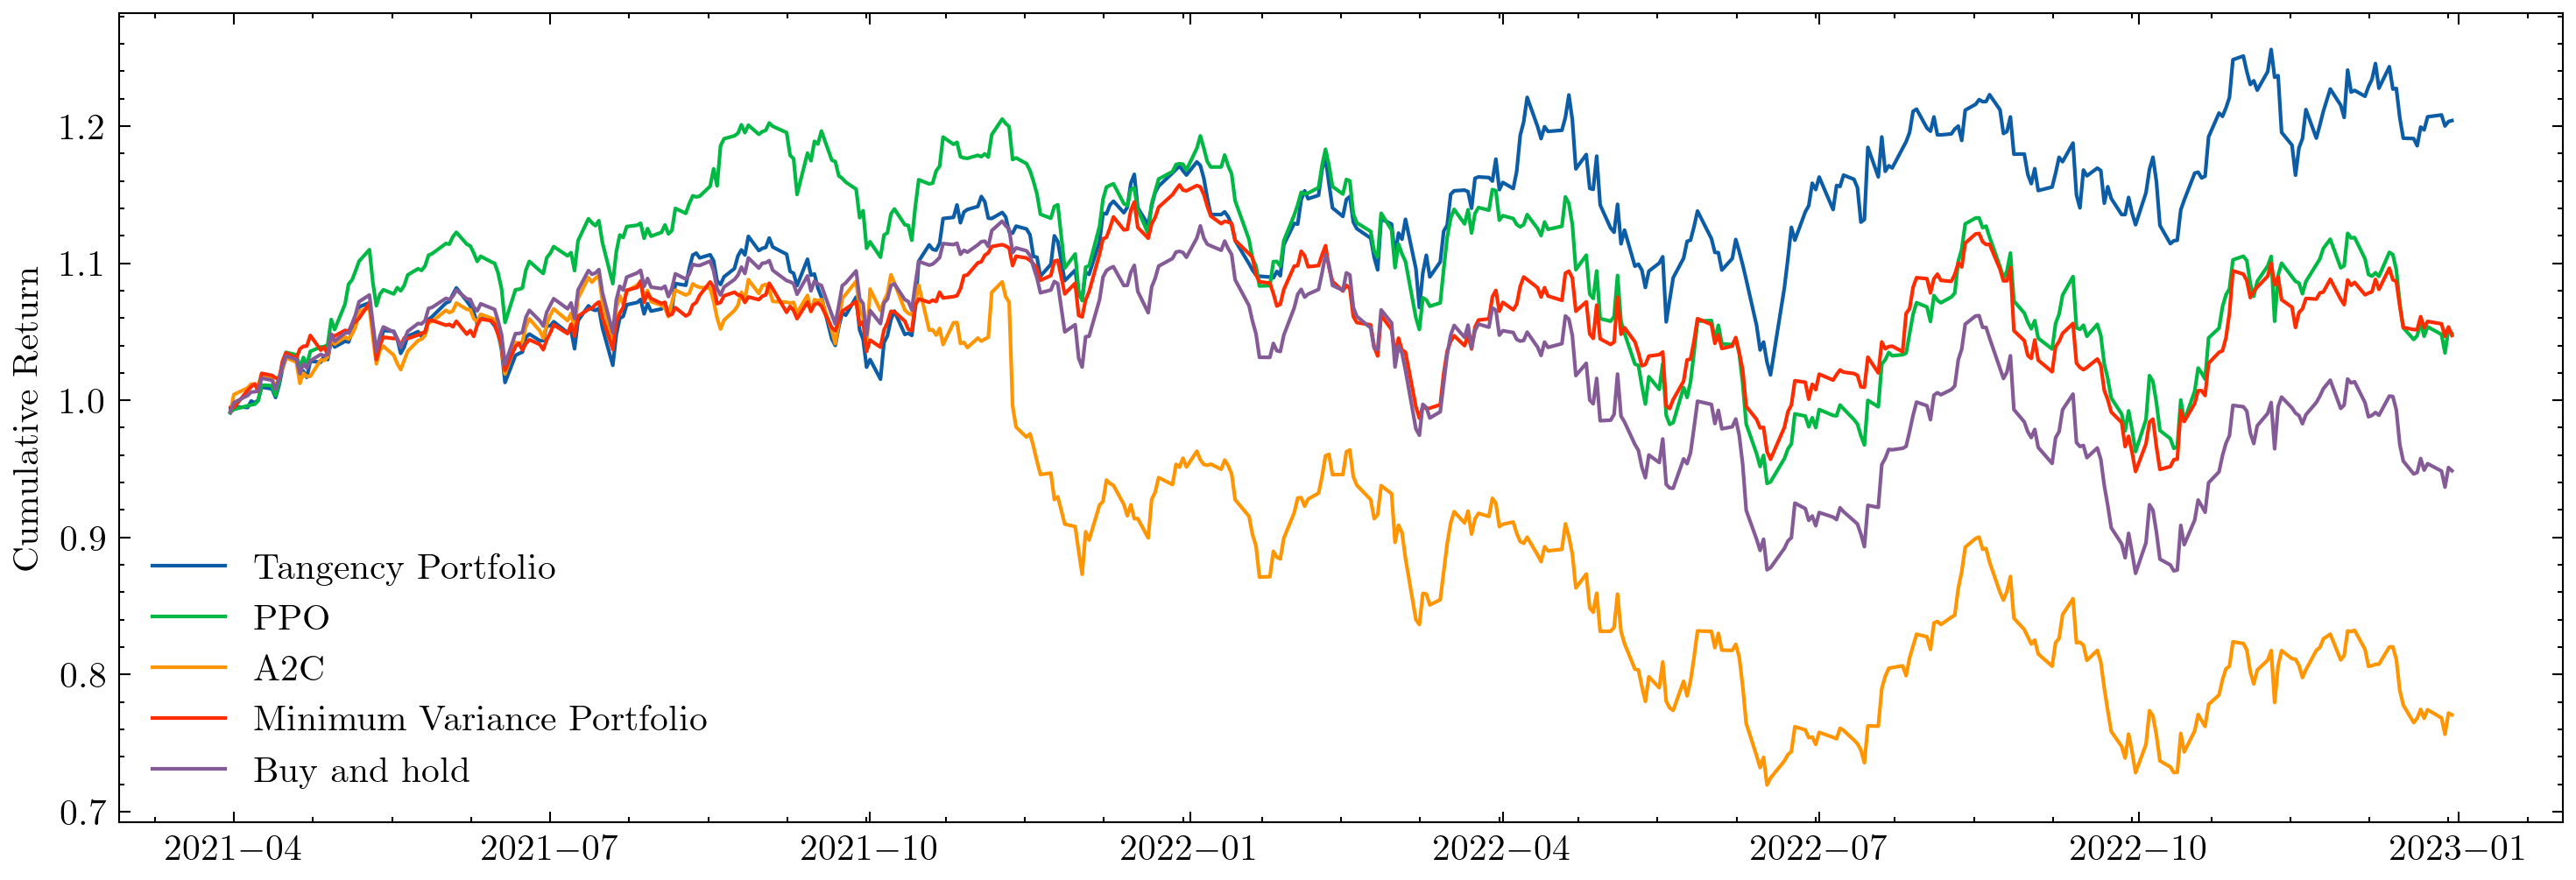

In [ ]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe['test'].date,(result_sharpe['test'].total_assets.pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(a2c_test_result[0].get('date'),(a2c_test_result[0]['account'].pct_change() +1).cumprod(),label='A2C')
    plt.plot(min_variacen_portfolio['test'].date,(min_variacen_portfolio['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

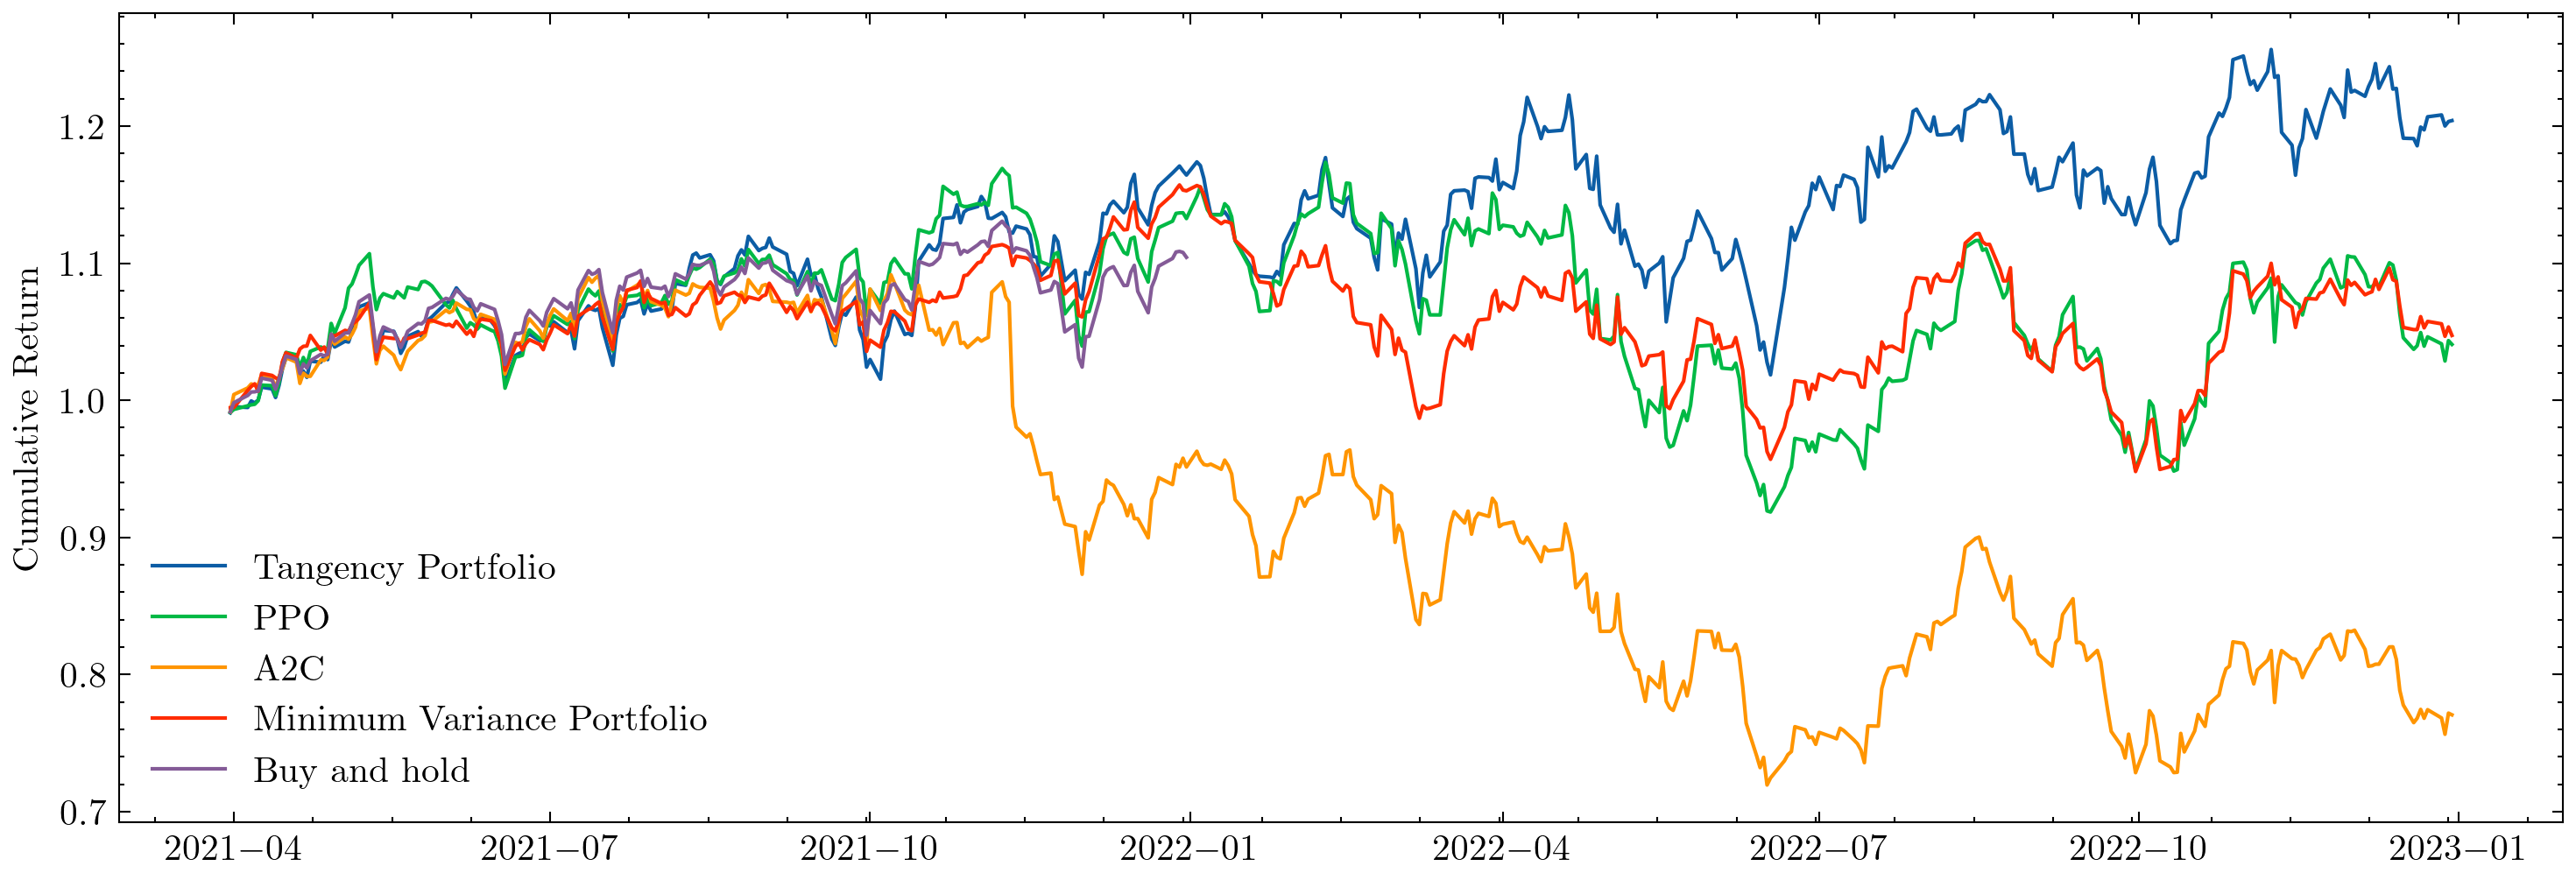

In [ ]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe['test'].date,(result_sharpe['test'].total_assets.pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(a2c_test_result[0].get('date'),(a2c_test_result[0]['account'].pct_change() +1).cumprod(),label='A2C')
    plt.plot(min_variacen_portfolio['test'].date,(min_variacen_portfolio['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

In [ ]:
import quantstats as qs

In [ ]:
ppo_returns = ppo_test_result[0][['date','account']]

ppo_stats={}
ppo_returns.set_index('date',inplace=True)
ppo_stats['name']  = 'Proximal Policy Optimization'
ppo_stats['sharpe_ratio'] = qs.stats.sharpe(ppo_returns)['account']
ppo_stats['max_drow_down'] = qs.stats.max_drawdown(ppo_returns)['account']
ppo_stats['var'] = qs.stats.var(ppo_returns)[0].item()
ppo_stats['return'] = qs.stats.comp(ppo_returns['account'].pct_change())
ppo_stats

{'name': 'Proximal Policy Optimization',
 'sharpe_ratio': np.float64(0.3388092143131057),
 'max_drow_down': np.float64(-0.2664428956423516),
 'var': -0.02301269977821848,
 'return': np.float64(0.09390949999999965)}

In [ ]:
mvo_min_returns = min_variacen_portfolio['test'][['date','total_assets']]
mvo_min_returns.set_index('date',inplace=True)

mvo_min_stats={}
mvo_min_stats['name']  = 'Min variance portfolio'
mvo_min_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_min_returns)['total_assets']
mvo_min_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_min_returns)['total_assets']
mvo_min_stats['var']  = qs.stats.var(mvo_min_returns)[0].item()
mvo_min_stats['return'] = qs.stats.comp(mvo_min_returns['total_assets'].pct_change())
mvo_min_stats

{'name': 'Min variance portfolio',
 'sharpe_ratio': np.float64(0.2633164866290335),
 'max_drow_down': np.float64(-0.18063587669076375),
 'var': -0.01639642306661718,
 'return': np.float64(0.05302095955995423)}

In [ ]:

mvo_sharpe_returns = result_sharpe['test'][['date','total_assets']]
mvo_sharpe_returns.set_index('date',inplace=True)
mvo_sharpe_stats={}
mvo_sharpe_stats['name']  = 'Tangency Portfolio'
mvo_sharpe_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_sharpe_returns)['total_assets']
mvo_sharpe_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_sharpe_returns)['total_assets']
mvo_sharpe_stats['var']  = qs.stats.var(mvo_sharpe_returns)[0].item()
mvo_sharpe_stats['return'] = qs.stats.comp(mvo_sharpe_returns['total_assets'].pct_change())
mvo_sharpe_stats

{'name': 'Tangency Portfolio',
 'sharpe_ratio': np.float64(0.666227580986604),
 'max_drow_down': np.float64(-0.16693110888675866),
 'var': -0.019609587852893476,
 'return': np.float64(0.21507314715763637)}

In [ ]:
bh_df = pd.DataFrame()
bh_df['asset']=environment_train_buy_and_hold_sp500._portfolio_return_memory
bh_df['date']=environment_train_buy_and_hold_sp500._date_memory
bh_df.set_index('date',inplace=True)
bh_stats={}
bh_stats['name']  = 'Buy and Hold'
bh_stats['sharpe_ratio'] = qs.stats.sharpe(bh_df)['asset']
bh_stats['max_drow_down'] = qs.stats.max_drawdown(bh_df)['asset']
bh_stats['var'] = qs.stats.var(bh_df)[0].item()
bh_stats['return'] = qs.stats.comp(bh_df['asset'])

bh_stats

{'name': 'Buy and Hold',
 'sharpe_ratio': np.float64(-0.06122215468658751),
 'max_drow_down': np.float64(-0.22713166127519646),
 'var': -0.019835048058484694,
 'return': np.float64(-0.051356343491552825)}

In [ ]:
stats = [bh_stats,mvo_sharpe_stats,mvo_min_stats,ppo_stats]

In [ ]:
stats_df = pd.DataFrame(stats)

In [ ]:
stats_df

name  sharpe_ratio  max_drow_down       var  \
0                  Buy and Hold     -0.061222      -0.227132 -0.019835   
1            Tangency Portfolio      0.666228      -0.166931 -0.019610   
2        Min variance portfolio      0.263316      -0.180636 -0.016396   
3  Proximal Policy Optimization      0.338809      -0.266443 -0.023013   

     return  
0 -0.051356  
1  0.215073  
2  0.053021  
3  0.093909

In [ ]:
with open('mytable.tex', 'w') as tf:
     tf.write(stats_df.to_latex())